In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

In [ ]:
'roe', 'roic', 'roa', 'ebit_ev'

In [ ]:
files = os.listdir('fake_data')
for file in files:
    df = pd.read_csv('fake_data//'+file, index_col='Date', parse_dates=True)
    df.drop(['Dividends', 'Split'], axis=1, inplace=True)
    n = len(df)
    
    #Roe
    roe_mean = 60
    roe_scale = 25
    roe = norm.rvs(loc=roe_mean, scale=roe_scale, size=n)
    df['roe'] = roe

    #roic
    roic_mean = 20
    roic_scale = 10
    roic = norm.rvs(loc=roic_mean, scale=roic_scale, size=n)
    df['roic'] = roic

    #roa
    roa_mean = 40
    roe_scale = 15
    roa = norm.rvs(loc=roa_mean, scale=roe_scale, size=n)
    df['roa'] = roa

    #ebit_ev
    ebit_mean = 25
    ebit_scale = 10
    ebit = norm.rvs(loc=ebit_mean, scale=ebit_scale, size=n)
    df['ebit_ev'] = ebit

    df.to_csv('fake_data//'+file, index='Date', sep=',')

2020-12-30, Reducing position: ABEV3
2020-12-30, Reducing position: BBAS3
2020-12-30, Reducing position: BBDC3
2020-12-30, Reducing position: BBDC4
2020-12-30, Reducing position: BBSE3
2020-12-30, Increasing position: ALPA4
2020-12-30, Increasing position: AMER3
2020-12-30, Increasing position: B3SA3
2020-12-30, SELL EXECUTED, Price: 15.00, Cost: -375.00, Comm 0.00
2020-12-30, SELL EXECUTED, Price: 20.98, Cost: -1447.62, Comm 0.00
2020-12-30, SELL EXECUTED, Price: 24.45, Cost: -880.20, Comm 0.00
2020-12-30, BUY EXECUTED, Price: 48.00, Cost: 4464.00, Comm 0.00
2020-12-30, BUY EXECUTED, Price: 24.50, Cost: 3601.50, Comm 0.00
2020-12-30, BUY EXECUTED, Price: 6.36, Cost: 4471.08, Comm 0.00
2020-12-30, Selling: BBDC4
2020-12-30, Increasing position: ABEV3
2020-12-30, Increasing position: ALPA4
2020-12-30, Increasing position: AMER3
2020-12-30, Increasing position: AZUL4
2020-12-30, Increasing position: B3SA3
2020-12-30, Increasing position: BBAS3
2020-12-30, Increasing position: BBDC3
2020-

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-01-02  2009-01-02
End Period                 2020-12-30  2020-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          4.53%       217.73%
CAGR﹪                     0.37%       10.11%

Sharpe                     0.09        0.51
Smart Sharpe               0.08        0.49
Sortino                    0.11        0.72
Smart Sortino              0.11        0.7
Sortino/√2                 0.08        0.51
Smart Sortino/√2           0.08        0.5
Omega                      1.02        1.02

Max Drawdown               -22.72%     -48.63%
Longest DD Days            2312        2497
Volatility (ann.)          7.98%       25.84%
R^2                        0.07        0.07
Calmar                     0.02        0.21
Skew                       -3.3        -0.43
Kurtosis                   63.49       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-09-01,2018-11-07,2020-12-30,2312,-22.721123,-22.113819
2,2010-02-24,2010-05-20,2014-07-21,1608,-15.562608,-13.914163
3,2014-07-30,2014-07-31,2014-08-13,14,-2.169203,-1.948952
4,2009-01-30,2009-03-02,2009-03-23,52,-2.023776,-1.892419
5,2009-06-01,2009-07-22,2009-11-06,158,-1.351652,-1.247192


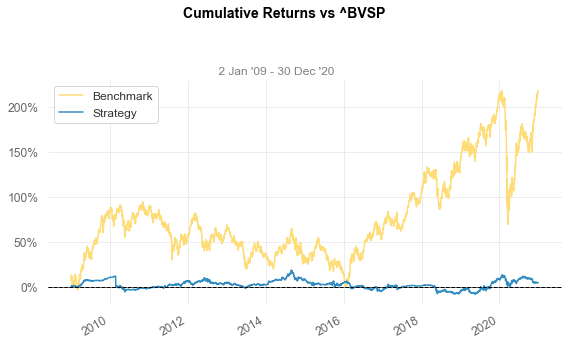

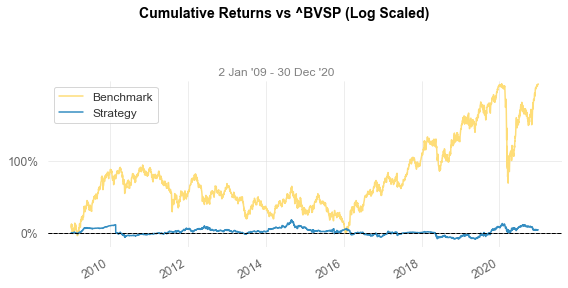

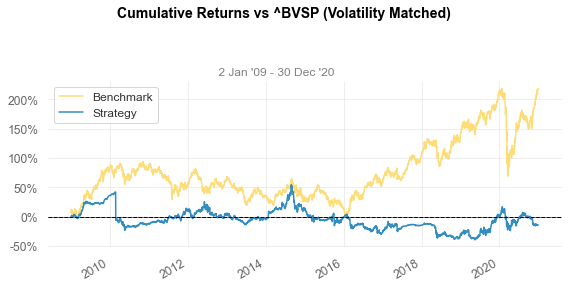

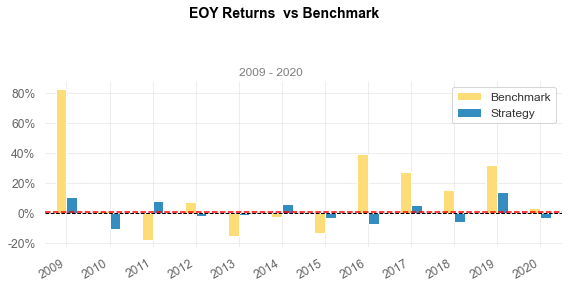

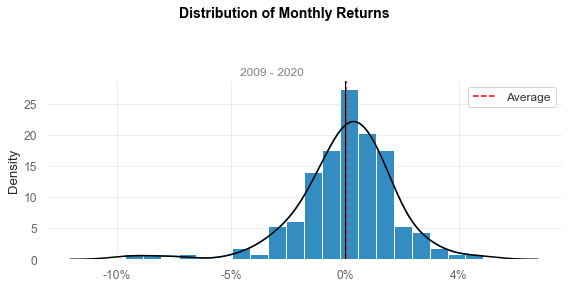

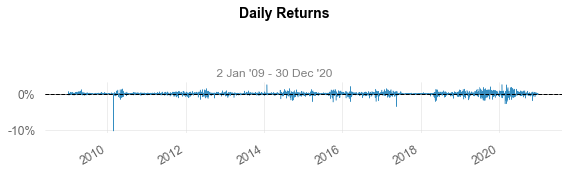

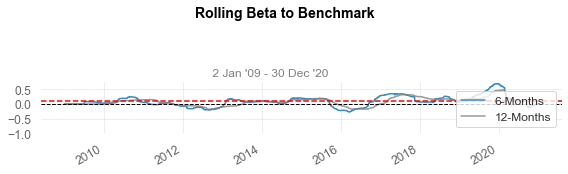

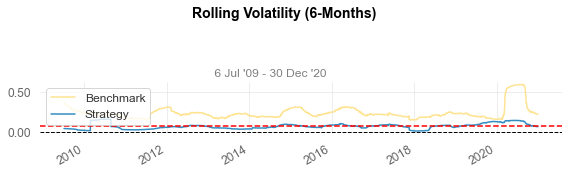

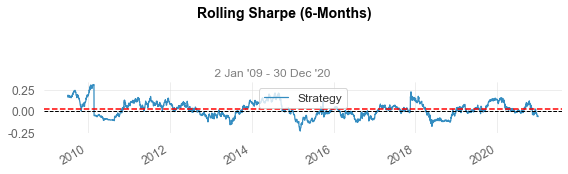

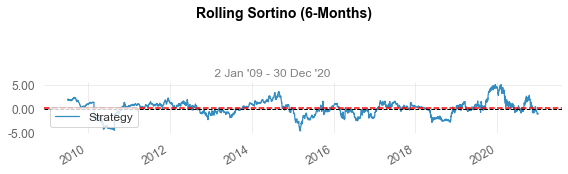

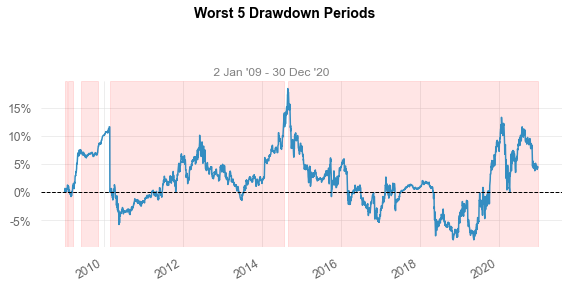

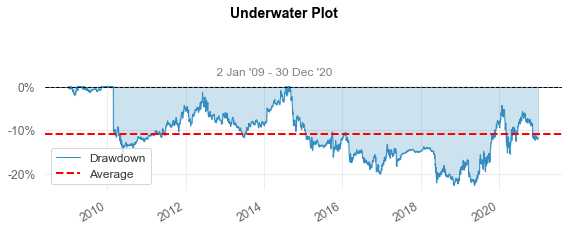

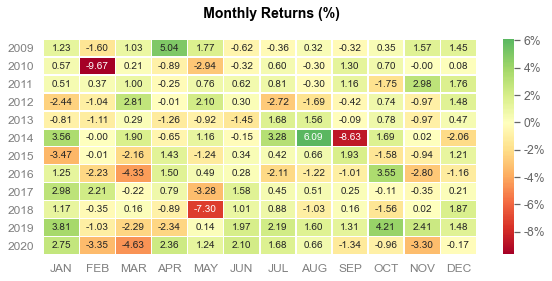

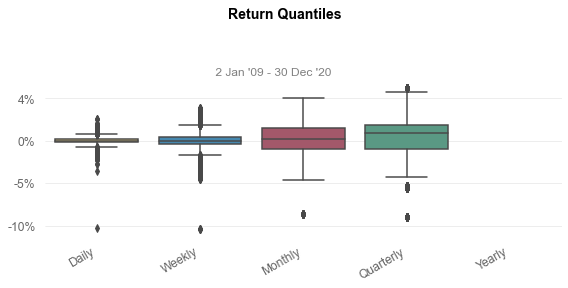

Average Holding: 99
Average Win Holding: 126
Average Loss Holding: 84


In [55]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import OrderedDict


#Numerical operations
import numpy as np
from numpy.linalg import inv

# Import the backtrader platform
import backtrader as bt
import backtrader.analyzers as btanalyzers

#Module to analyze portfolio
import pyfolio as pf
import quantstats as qs

#debugging
from ipdb import set_trace

#ploting
import matplotlib.pyplot as plt

#operating system module
import os

#data analysis module
import pandas as pd

#Datetime library
import datetime as dt

from stochastic_diff_equations import gBm


class GenericCSVData(bt.feeds.GenericCSVData):
    lines = ('adj_close', 'roe', 'roic', 'roa', 'ebit_ev') 
    params = dict(
        adj_close=5,
        volume=6,
        roe=7,
        roic=8,
        roa=9,
        ebit_ev=10,
        dtformat='%Y-%m-%d',  # fix date format a yyyy-mm-dd
        openinterest=-1,  # -1 indicates there is no openinterest field
        
    )


class kelly_criterion():
    def __init__(self):
        pass
    
    def gBm(self, μ:list, σ:list, ρ=0, independent=True):
        self.μ = μ
        self.σ = σ
        N = len(μ)
        A = self.A
        B = self.B
        if independent:
            M = np.array([[A(l) if l==l_ else B(l)*B(l_) for l in range(N)] for l_ in range(N)])
        else:
            Mij = np.exp(μ[0]+μ[1]+ρ*σ[0]*σ[1]) - np.exp(μ[0]) - np.exp(μ[1]) + 1 #s.t. i!=j
            M = np.array([[A(l) if l==l_ else Mij for l in range(N)] for l_ in range(N)])
        b = np.array([B(l) for l in range(N)])
        
        return np.dot(inv(M), b)
    
    def B(self, l):
        μ = self.μ
        return np.exp(μ[l]) - 1
    
    def A(self, l):
        μ = self.μ
        σ = self.σ
        return 1 - 2*np.exp(μ[l]) + np.exp(2*μ[l] + σ[l])
    
class momentumStrat(bt.Strategy):    
    params = dict(
        enableLog=True, 
        gBmSize=2**8+1,
        rebal_monthday=1,
        stocks_in_portfolio=8,
        first_filter='d.roa', 
        second_filter='d.ebit_ev',
        long_only=False)
        #filtros disponiveis: roa, roic, roe, ebit_ev 
        #obs - sempre coloque o "d." para que funcione coretamente no código
    
    def __init__(self):
        
        self.order = None
        

        gBms = [gBm(d, size=self.p.gBmSize) for d in self.datas]
        driftAcoes = [gBm.μ for gBm in gBms]
        volatAcoes = [gBm.σ for gBm in gBms]

        self.driftAcoes = {d:drift for d, drift in zip(self.datas, driftAcoes)}
        self.volatAcoes = {d:volat for d, volat in zip(self.datas, volatAcoes)}

        self.add_timer(
            when=bt.Timer.SESSION_START,
            monthdays=[self.p.rebal_monthday],
            monthcarry=True  # if a day isn't there, execute on the next
        )

        
        
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)
        
        elif order.status==order.Canceled:
            self.log('Order Canceled. Price: {}'.format(order.price))
        elif order.status==order.Margin:
            self.log('Order Margin. Price: {}'.format(order.price))
        elif order.status==order.Rejected:
            self.log('Order Rejected. Price: {}'.format(order.price))

        self.order = None

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.enableLog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
    
    
    def notify_timer(self, timer, when, *args, **kwargs):
        if  self.order:
            return
        
        #creating the formula for the current period
        first_rank = {d._name:eval(self.p.first_filter)[0] for d in self.datas}
        second_rank = {d._name:eval(self.p.second_filter)[0] for d in self.datas}

        
        first_rank = pd.DataFrame(first_rank, index=['first_filter']).T
        second_rank = pd.DataFrame(second_rank, index=['second_filter']).T
        magic_formula = pd.concat([first_rank, second_rank], axis=1) 
        
        #index | first_filter | second_filter
        #  A   |       a00    |      a01
        #  B   |       a10    |      a11

        magic_formula['first_filter_rank'] = magic_formula['first_filter'].rank(ascending=False, method='first')
        magic_formula['second_filter_rank'] = magic_formula['second_filter'].rank(ascending=False, method='first')
        magic_formula['MAGIC_FORMULA_rank'] = magic_formula['first_filter_rank']+magic_formula['second_filter_rank']
        magic_formula.sort_values('MAGIC_FORMULA_rank', axis=0, inplace=True)


        #selecting top companies with highest rank
        top_ranks = [d for d in self.datas if d._name in magic_formula.index[:self.p.stocks_in_portfolio]]
        
        #getting companies current parameters (index 0 approach)
        winners_μ = [self.driftAcoes[winner][0] for winner in top_ranks]
        winners_σ = [self.volatAcoes[winner][0] for winner in top_ranks]

        #estimating weights based on kelly criterion for selected stocks
        winners_w = kelly_criterion().gBm(winners_μ, winners_σ)

        #Long only strategy
        if self.p.long_only:
            winners_w = winners_w[winners_w>0]

        #current positions opened in portfolio
        current_positions = [d for d, pos in self.getpositions().items() if pos]

        
        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in [d for d in current_positions if d not in top_ranks]:
            self.log('Selling: {}'.format(d._name))
            self.order = self.order_target_percent(d, target=0.0)

        
        #separate companies in which we're going to increase position size
        # vs decrease position size
        reduce_pos = []
        increase_pos = []
        for winner,bet_target in zip(top_ranks, winners_w):
            winner_pos_size = self.getposition(winner, self.broker).size
            if winner_pos_size>bet_target:
                reduce_pos.append((winner, bet_target))
            else:
                increase_pos.append((winner, bet_target))
        
        
        for winner, bet_target in reduce_pos:
            self.log('Reducing position: {}'.format(winner._name))
            self.order_target_percent(winner, target=bet_target)
        
        for winner, bet_target in increase_pos:
            self.log('Increasing position: {}'.format(winner._name))
            self.order_target_percent(winner, target=bet_target)
        
        
    def stop(self):
        self.log('Ending Value %.2f' %
                 (self.broker.getvalue()), doprint=True)
    

def runStrat(start, end):
    cerebro = bt.Cerebro()
    
    #Set cash value
    cerebro.broker.set_cash(100000)
    
    #Set commission model
    cerebro.broker.setcommission(commission=0)
    
    cerebro.broker.set_checksubmit(False)
    

    #Adding data
    start=dt.datetime.strptime(start, '%Y-%m-%d')
    end=dt.datetime.strptime(end, '%Y-%m-%d')

    files = os.listdir('fake_data')
    for file in files:
        datapath = 'fake_data//'+file
        data = GenericCSVData(
            dataname=datapath,
            fromdate=start,
            todate=end)
        cerebro.adddata(data)
    
    
    
    #Add analyzers
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeAnalyzer')
    
    #Add Strategy    
    cerebro.addstrategy(momentumStrat)
    
    #Run Algo
    results = cerebro.run(maxcpus=1)

    
    #Plot results
    #cerebro.plot()
    
    return results

def pyfolio_analyze_strat(results, live):
    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

    benchmark_rets = pd.read_csv('^BVSP.csv', index_col='Date')[['Adj Close']]
    benchmark_rets.rename(columns={'Adj Close':'Benchmark - IBOV'}, inplace=True)
    benchmark_rets = benchmark_rets.pct_change()[1:]
    benchmark_rets = benchmark_rets['Benchmark - IBOV'] #convert dataframe to pandas series
    benchmark_rets.index = pd.to_datetime(benchmark_rets.index)
    benchmark_rets.loc[benchmark_rets.index>=live]
    benchmark_rets.index = benchmark_rets.index.tz_localize("UTC")
    
    pf.create_full_tear_sheet(
        returns=returns,
        positions=positions,
        transactions=transactions,
        live_start_date=live,  # This date is sample specific
        estimate_intraday=False
    )

def qs_analyze_strat(results):
    strat = results[0]
    analyzers = strat.analyzers

    #Get returns with pyfolio
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    returns.index = pd.to_datetime(returns.index.astype(str).str[:10])

    #Create report with quantstats
    qs.reports.full(returns, '^BVSP')

    #Get more analytics insight about strategy
    tradeAnalyzer = analyzers.tradeAnalyzer.get_analysis()
    average_holding = int(tradeAnalyzer['len']['average'])
    average_win_holding = int(tradeAnalyzer['len']['won']['average'])
    average_loss_holding = int(tradeAnalyzer['len']['lost']['average'])

    
    print('Average Holding: {}'.format(average_holding))
    print('Average Win Holding: {}'.format(average_win_holding))
    print('Average Loss Holding: {}'.format(average_loss_holding))

if __name__=='__main__':
    live = '2020-06-01'
    r = runStrat('2009-01-01', '2020-12-31')
    qs_analyze_strat(r)